# **Notes:**
# **To use this model correctly:**
>  # 1. Create a file in your drive named "Submission.csv" that contains 2 columns: "client_id" and "target" to save the results







In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd drive/MyDrive/Dataset

/content/drive/MyDrive/Dataset


In [ ]:
import numpy as np
import pandas as pd
import datetime
import gc
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import mean_squared_error, roc_auc_score, accuracy_score, f1_score
from sklearn.preprocessing import LabelEncoder
import joblib
import warnings

warnings.filterwarnings('ignore')
np.random.seed(4590)

# Load the data
train_client = pd.read_csv('client_train.csv')
test_client = pd.read_csv('client_test.csv')
train_invoice = pd.read_csv('invoice_train.csv')
test_invoice = pd.read_csv('invoice_test.csv')
sub = pd.read_csv('Submission.csv')

# Label encoding the counter_type
train_invoice['counter_type'] = train_invoice['counter_type'].map({"ELEC": 0, "GAZ": 1})
test_invoice['counter_type'] = test_invoice['counter_type'].map({"ELEC": 0, "GAZ": 1})

# Convert object columns to categorical data type
train_client['client_catg'] = train_client['client_catg'].astype('category')
train_client['disrict'] = train_client['disrict'].astype('category')
test_client['client_catg'] = test_client['client_catg'].astype('category')
test_client['disrict'] = test_client['disrict'].astype('category')

# Convert invoice date to datetime
for df in [train_invoice, test_invoice]:
    df['invoice_date'] = pd.to_datetime(df['invoice_date'])

# Aggregate invoice data
aggs = {
    'consommation_level_1': ['mean'],
    'consommation_level_2': ['mean'],
    'consommation_level_3': ['mean'],
    'consommation_level_4': ['mean']
}
agg_trans = train_invoice.groupby('client_id').agg(aggs)
agg_trans.columns = ['_'.join(col).strip() for col in agg_trans.columns.values]
agg_trans.reset_index(inplace=True)
agg_trans['transactions_count'] = train_invoice.groupby('client_id').size().values

# Merge aggregated invoice data with client data
train = pd.merge(train_client, agg_trans, on='client_id', how='left')
test = pd.merge(test_client, agg_trans, on='client_id', how='left')

# Drop unnecessary columns
cols_to_drop = ['client_id', 'creation_date']
train.drop(cols_to_drop, axis=1, inplace=True)
test.drop(cols_to_drop, axis=1, inplace=True)

# Label encode categorical features
label_encoder = LabelEncoder()
for f in train.columns:
    if train[f].dtype == 'category':
        train[f] = label_encoder.fit_transform(train[f])
        test[f] = label_encoder.transform(test[f])

# Fill missing values with 0
train.fillna(0, inplace=True)
test.fillna(0, inplace=True)

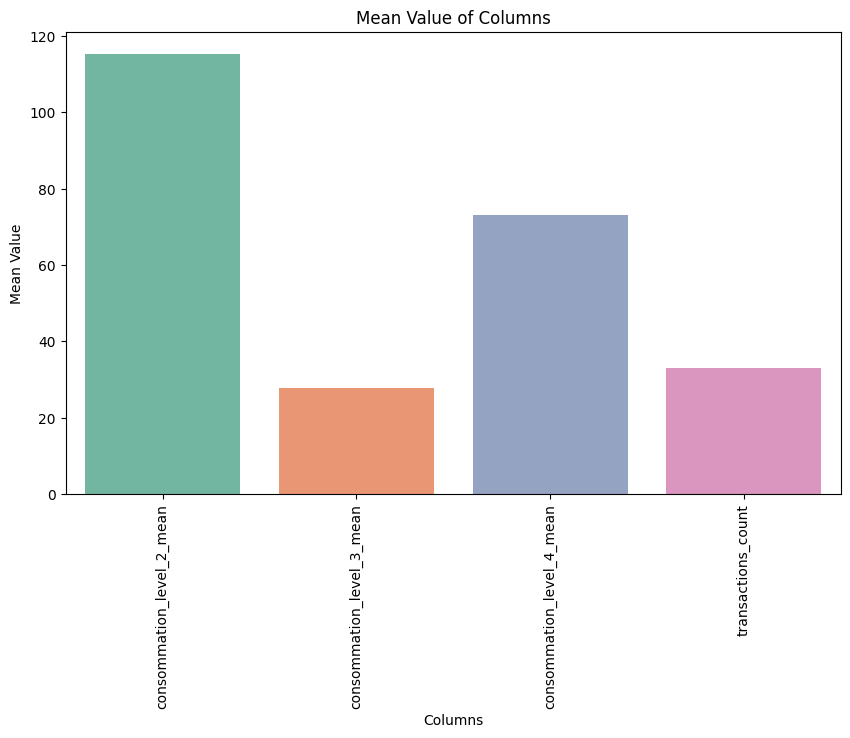

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(x=train.columns[5:], y=train.iloc[:, 5:].mean(), palette='Set2')
plt.xlabel('Columns')
plt.ylabel('Mean Value')
plt.title('Mean Value of Columns')
plt.xticks(rotation=90)
plt.show()

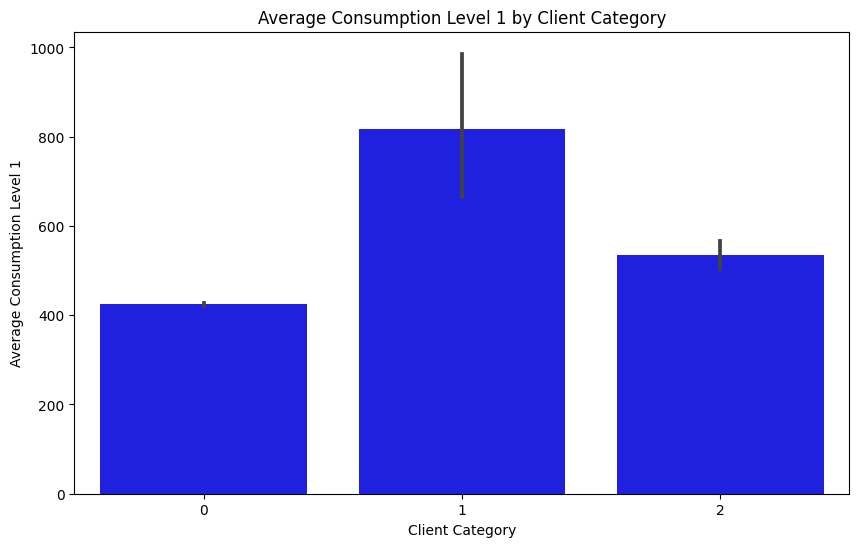

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(x='client_catg', y='consommation_level_1_mean', data=train, color='blue')
plt.xlabel('Client Category')
plt.ylabel('Average Consumption Level 1')
plt.title('Average Consumption Level 1 by Client Category')
plt.show()

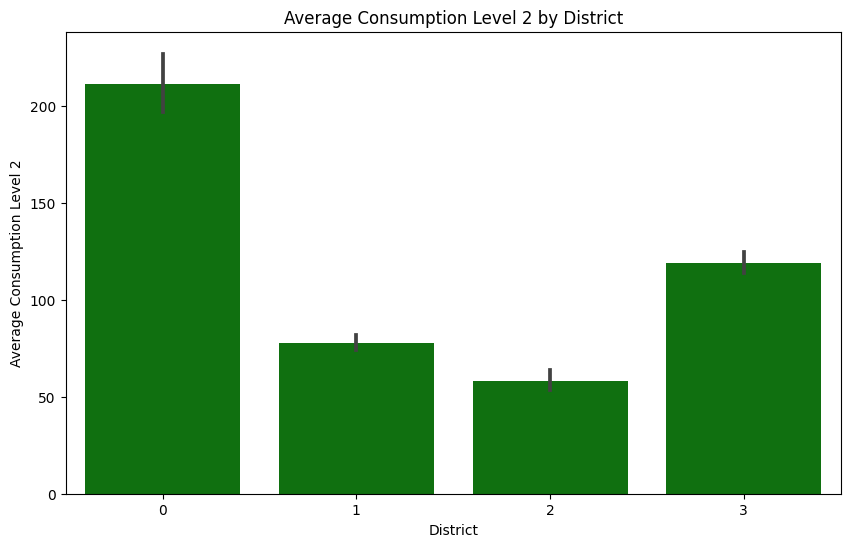

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(x='disrict', y='consommation_level_2_mean', data=train, color='green')
plt.xlabel('District')
plt.ylabel('Average Consumption Level 2')
plt.title('Average Consumption Level 2 by District')
plt.show()

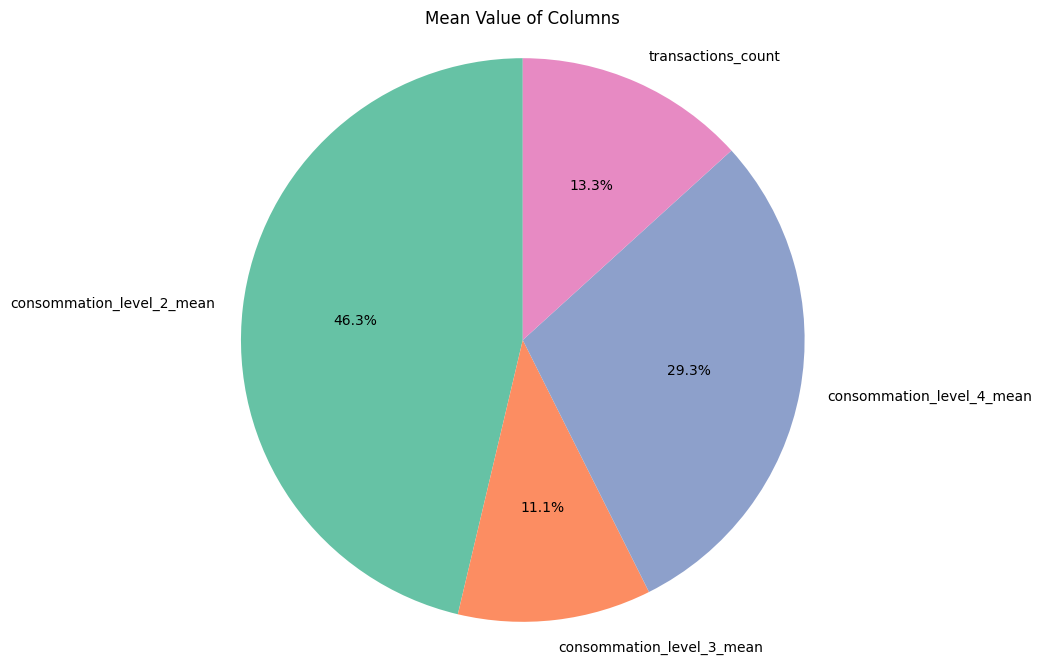

In [ ]:
plt.figure(figsize=(8, 8))
mean_values = train.iloc[:, 5:].mean()
labels = mean_values.index
colors = sns.color_palette('Set2', len(labels))
plt.pie(mean_values, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.title('Mean Value of Columns')
plt.axis('equal')
plt.show()

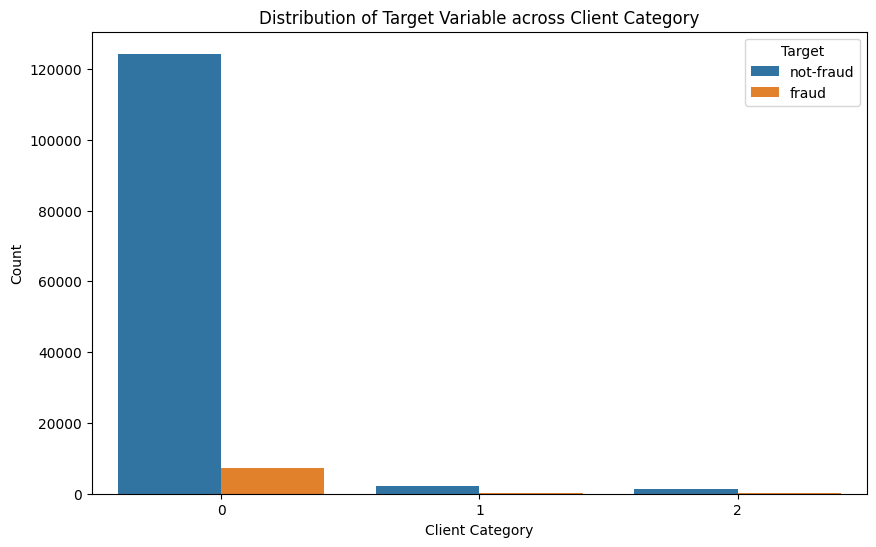

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(x='client_catg', hue='target', data=train)
plt.xlabel('Client Category')
plt.ylabel('Count')
plt.title('Distribution of Target Variable across Client Category')
plt.legend(title='Target', labels=['not-fraud', 'fraud'])
plt.show()

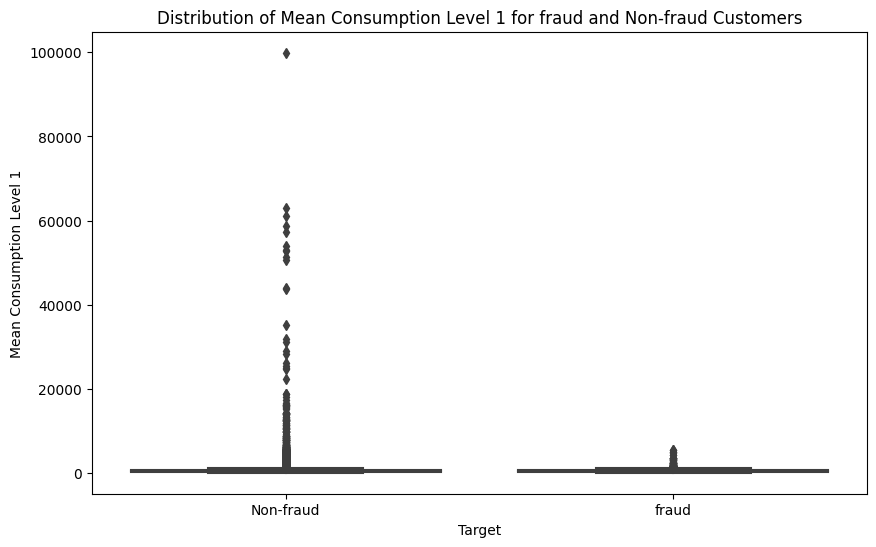

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='target', y='consommation_level_1_mean', data=train)
plt.xlabel('Target')
plt.ylabel('Mean Consumption Level 1')
plt.title('Distribution of Mean Consumption Level 1 for fraud and Non-fraud Customers')
plt.xticks([0, 1], ['Non-fraud', 'fraud'])
plt.show()

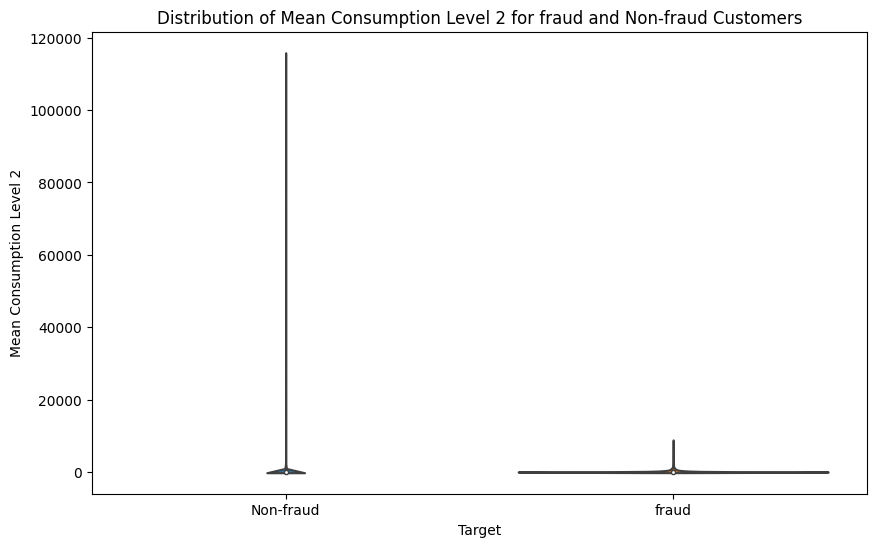

In [ ]:
plt.figure(figsize=(10, 6))
sns.violinplot(x='target', y='consommation_level_2_mean', data=train)
plt.xlabel('Target')
plt.ylabel('Mean Consumption Level 2')
plt.title('Distribution of Mean Consumption Level 2 for fraud and Non-fraud Customers')
plt.xticks([0, 1], ['Non-fraud', 'fraud'])
plt.show()

In [ ]:
# Define the target variable
target = train['target']

# Split the data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(train, target, test_size=0.2, random_state=4590)

# Define the model
model = lgb.LGBMClassifier(
    boosting_type='gbdt',
    objective='binary',
    num_leaves=31,
    learning_rate=0.05,
    feature_fraction=0.9,
    subsample=0.8,
    subsample_freq=1,
    n_estimators=1000,
    early_stopping_rounds=50
)

# Fit the model on the training data
model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=False
)

# Save the trained model
joblib.dump(model, 'model.pkl')

# Load the trained model
loaded_model = joblib.load('model.pkl')

# Create the target column in the test dataset
test['target'] = 0

# Make predictions on the test set
preds = loaded_model.predict_proba(test[X_train.columns])
preds = pd.DataFrame(preds)

# Prepare the submission file
submission = pd.DataFrame({
    "client_id": sub["client_id"],
    "target": preds[1]
})
submission.to_csv('Submission.csv', index=False)

# Calculate and display model accuracy
train_preds = loaded_model.predict(X_train)
train_accuracy = accuracy_score(y_train, train_preds)
print("Training Accuracy:", train_accuracy)

val_preds = loaded_model.predict(X_val)
val_accuracy = accuracy_score(y_val, val_preds)
print("Validation Accuracy:", val_accuracy)

[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
Training Accuracy: 1.0
Validation Accuracy: 1.0


In [ ]:
from sklearn.model_selection import StratifiedKFold
import numpy as np

# Define the number of folds for cross-validation
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=4590)

# Initialize an array to store the accuracies for each fold
accuracies = []

# Initialize empty arrays for predicted values
train_preds = np.zeros_like(target)
val_preds = np.zeros_like(target)

# Perform cross-validation
for train_index, val_index in skf.split(train, target):
    X_train, X_val = train.iloc[train_index], train.iloc[val_index]
    y_train, y_val = target.iloc[train_index], target.iloc[val_index]

    # Define the model
    model = lgb.LGBMClassifier(
        boosting_type='gbdt',
        objective='binary',
        num_leaves=31,
        learning_rate=0.05,
        feature_fraction=0.9,
        subsample=0.8,
        subsample_freq=1,
        n_estimators=1000,
        early_stopping_rounds=50,
    )

    # Fit the model on the training data
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)

    # Predict on training and validation data
    train_preds[val_index] = model.predict(X_val)
    val_preds += model.predict(train)

    # Calculate the validation accuracy for this fold
    accuracy = np.mean(train_preds[val_index] == y_val)
    accuracies.append(accuracy)

# Calculate the mean cross-validated accuracy
mean_accuracy = np.mean(accuracies)

# Calculate the validation accuracy across all folds
val_preds = val_preds.astype(np.int64)
val_preds //= n_splits
val_accuracy = np.mean(val_preds == target)


# Print the results
print("Training Accuracy:", np.mean(train_preds == target))
print("Validation Accuracy:", val_accuracy)
print("Mean Cross-Validated Accuracy:", mean_accuracy)

[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Curr

In [ ]:
# Make predictions on the test set
test_preds = loaded_model.predict(X_val)

# Calculate the test accuracy
test_accuracy = accuracy_score(y_val, test_preds)

# Print the test accuracy
print("Test Accuracy:", test_accuracy)

Test Accuracy: 1.0
